In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from fastai.basics import set_seed
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *
from fastrenewables.tabular.model import EmbeddingModule

import torch.nn.functional as F

#import glob

In [3]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x_cat, x_cont):
        z = self.gan.noise(x_cont)
        fake_samples = self.gan.generator(x_cat, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, lr=1e-3, plot_epochs=10, save_model=False):
        
        self.gan.to_device(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        self.gan.gen_optim.param_groups[0]['lr'] = lr
        self.gan.dis_optim.param_groups[0]['lr'] = lr
        
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                #x_cat[:] = 0
                x_cat = x_cat.to(self.gan.device).long()
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            if (e+1)%plot_epochs==0:
                plt.figure()
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                if len(self.gan.aux_loss) > 0:
                    plt.plot(self.gan.aux_loss, label='Aux Loss')
                plt.legend()
                plt.show()
        
        if save_model:
            self.gan.to_device('cpu')
        
        return

### Examples:

In [4]:
set_seed(1337)

n_samples = 1024*10
n_classes = 2
n_features = 1
batch_size = 1024
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 10
lr = 1e-5
n_gen = 1
n_dis = 1
aux_factor = 1/1 # 1/5

data = GaussianDataset(n_samples, n_classes)
#data = UniformDataset(n_samples, n_classes)

dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

emb = EmbeddingModule(categorical_dimensions=[n_classes+1])

100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


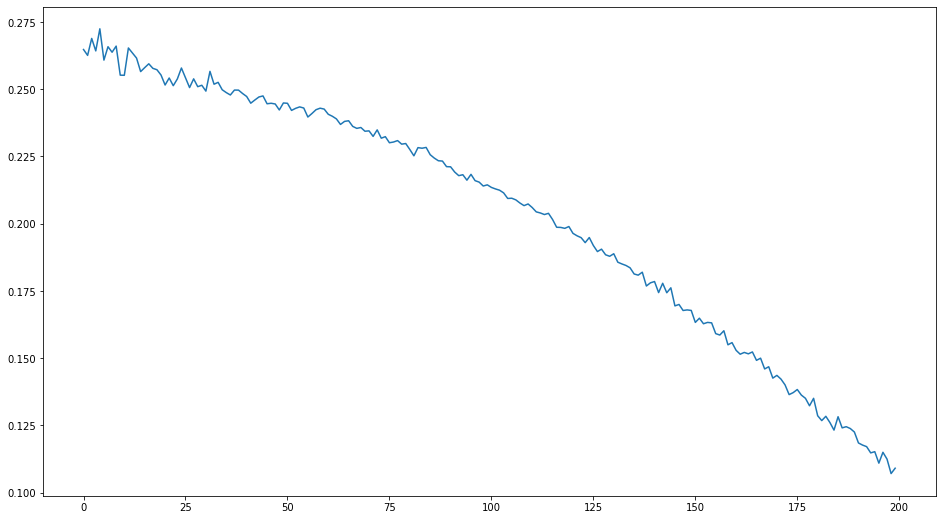

tensor([[0.2341],
        [0.2341],
        [0.2341],
        [0.2341],
        [0.2341],
        [0.2341],
        [0.6006],
        [0.6006],
        [0.6006],
        [0.6006],
        [0.6006],
        [0.6006]], grad_fn=<SliceBackward0>)
tensor(0.4174, grad_fn=<MeanBackward0>)


In [5]:
# test embeddings etc.

model = nn.Sequential(emb, nn.Linear(3, 3), nn.ReLU(), nn.Linear(3, 1))
optim = torch.optim.Adam(params=model.parameters())
mse_loss = nn.MSELoss()
#ce_loss = nn.CrossEntropyLoss()

plot_loss = []
for epoch in tqdm(range(epochs)):
    for x_cat, x_cont, y in dl:
        x_cat = x_cat.long()
        model.zero_grad()
        pred = model(x_cat)
        error = mse_loss(pred, y)
        error.backward()
        optim.step()
        plot_loss.append(error.item())

plt.figure(figsize=(16, 9))
plt.plot(plot_loss)
plt.show()

x_cat[:512] = 1
x_cat[512:1024] = 2
#x_cat[:] = 1

print(model(x_cat)[506:518])
print(model(x_cat).mean())

In [6]:
set_seed(1337)

n_samples = 1024*100
n_classes = 2
n_features = 1
batch_size = 1024
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 100
lr = 1e-5
n_gen = 1
n_dis = 1
aux_factor = 1/1 # 1/5

data = GaussianDataset(n_samples, n_classes)
#data = UniformDataset(n_samples, n_classes)

dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

emb = EmbeddingModule(categorical_dimensions=[n_classes+1])

model = get_gan_model(gan_type='bce', structure=[n_z, n_hidden, n_hidden, n_in], n_classes=n_classes, emb_module=emb, bn=False, aux_factor=aux_factor)
print(model)

learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)

GAN(
  (generator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(3, 3)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=13, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
      )
      (3): Sigmoid()
    )
  )
  (discriminator): GANMLP(
    (embedding_module): EmbeddingModule(
      (embeddings): ModuleList(
        (0): Embedding(3, 3)
      )
    )
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
 

 99%|█████████▉| 99/100 [08:24<00:03,  3.03s/it]

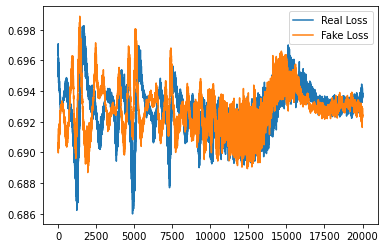

100%|██████████| 100/100 [08:27<00:00,  5.07s/it]


In [7]:
learner.fit(dl, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)

In [8]:
#print(emb(torch.ones_like(x_cat)*0))
print(emb(torch.ones_like(x_cat)*1))
print(emb(torch.ones_like(x_cat)*2))
print(emb(x_cat))

tensor([[-0.1340, -0.1982, -0.2093],
        [-0.1340, -0.1982, -0.2093],
        [-0.1340, -0.1982, -0.2093],
        ...,
        [-0.1340, -0.1982, -0.2093],
        [-0.1340, -0.1982, -0.2093],
        [-0.1340, -0.1982, -0.2093]], grad_fn=<CatBackward0>)
tensor([[ 0.1536, -0.1758, -0.0358],
        [ 0.1536, -0.1758, -0.0358],
        [ 0.1536, -0.1758, -0.0358],
        ...,
        [ 0.1536, -0.1758, -0.0358],
        [ 0.1536, -0.1758, -0.0358],
        [ 0.1536, -0.1758, -0.0358]], grad_fn=<CatBackward0>)
tensor([[-0.1340, -0.1982, -0.2093],
        [-0.1340, -0.1982, -0.2093],
        [-0.1340, -0.1982, -0.2093],
        ...,
        [ 0.1536, -0.1758, -0.0358],
        [ 0.1536, -0.1758, -0.0358],
        [ 0.1536, -0.1758, -0.0358]], grad_fn=<CatBackward0>)


distribution of real data:


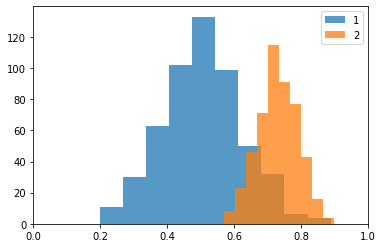

distribution of generated data:


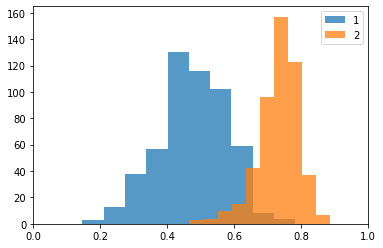

distribution of generated data:


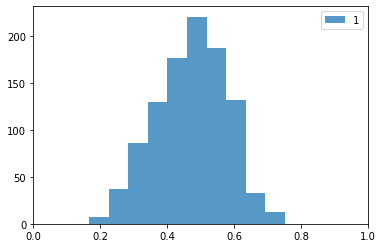

distribution of generated data:


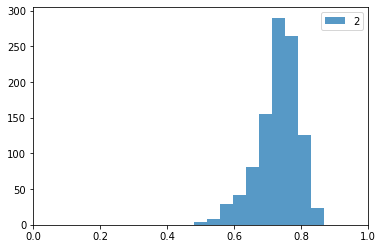

In [9]:
set_seed(1337)

for x_cat, x_cont, y in dl:
    x_cat = x_cat.long()
    #x_cat[:] = 1
    print('distribution of real data:')
    plot_class_hists(x_cat, x_cont)
    
    x_fake = learner.generate_samples(x_cat, x_cont)
    print('distribution of generated data:')
    plot_class_hists(x_cat, x_fake.detach())
    
    x_cat[:] = 1
    x_fake = learner.generate_samples(x_cat, x_cont)
    print('distribution of generated data:')
    plot_class_hists(x_cat, x_fake.detach())
    
    x_cat[:] = 2
    x_fake = learner.generate_samples(x_cat, x_cont)
    print('distribution of generated data:')
    plot_class_hists(x_cat, x_fake.detach())
    break

#real_d = torch.distributions.Normal(x_cont.mean(), x_cont.var()).log_prob(torch.linspace(0, 1, 1000))
#fake_d = torch.distributions.Normal(x_fake.mean(), x_fake.var()).log_prob(torch.linspace(0, 1, 1000))
#
#pq = F.kl_div(real_d, fake_d, reduction='batchmean', log_target=True)
#qp = F.kl_div(fake_d, real_d, reduction='batchmean', log_target=True)
#
#kl_div = (pq+qp)/2
#kl_div